# Install and imports

In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import datasets, layers, models
import inspect
import statistics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from keras_tuner import HyperModel, RandomSearch
import keras_tuner as kt

## Random seed

In [4]:
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Download and pre-process images

In [5]:
# Access the data file from google drive.
# Please ignore this code block if you have your files locally.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path of the image
image_path = "drive/MyDrive/IMGS-TESIS-NUEVAS/Imagenes catalogadas"
image_list = os.listdir(image_path)
print("Number of images:", len(image_list))

Number of images: 47


In [7]:
images = []
labels = []


for image_name in image_list:
    path = os.path.join(image_path, image_name)
    image = Image.open(path,)
    image = image.resize((250, 250))

    # Convert to GrayScale
    if image.mode != 'L':
        image = image.convert('L')


    image_array = np.array(image)
    images.append(image_array)


    if image_name.startswith("PVA_MCC_0"):
        labels.append(33.18)
    elif image_name.startswith("PVA_MCC_1"):
        labels.append(18.87)
    elif image_name.startswith("PVA_MCC_3"):
        labels.append(18.74)
    elif image_name.startswith("PVA_MCC_5"):
        labels.append(14.23)


images = np.array(images)
labels = np.array(labels)


images = images.reshape(-1, 250, 250, 1)

# Data Augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=5,
    zoom_range=0.1,
    vertical_flip=True,
    fill_mode="wrap"
)


datagen.fit(images)


augmented_images = []
augmented_labels = []


for i in range(40):
    it = datagen.flow(images, labels, shuffle=False)
    batch_images, batch_labels = next(it)

    augmented_images.append(batch_images)
    augmented_labels.append(batch_labels)


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


final_images = np.concatenate((images, augmented_images))
final_labels = np.concatenate((labels, augmented_labels))

print("Final dataset size:", len(final_images))

Final dataset size: 1327


Text(0.5, 1.0, 'Tensile strength18.87')

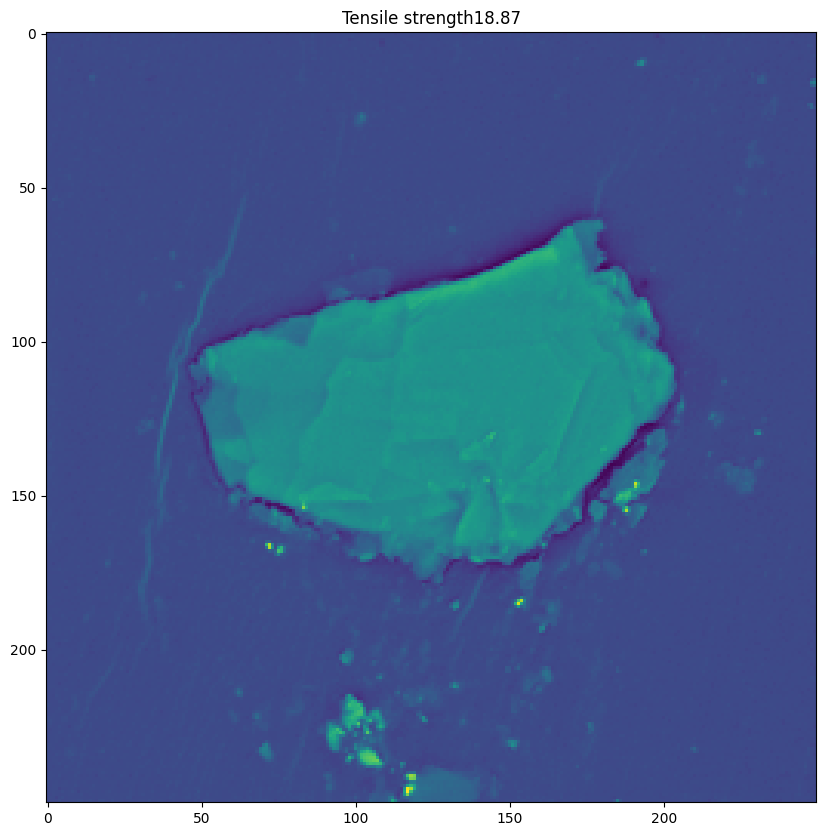

In [8]:
#Plot the images
plt.figure(figsize=(10,10))
plt.imshow(images[42])
plt.title("Tensile strength"+str(labels[42]))

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.15, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [10]:
train_images = tf.convert_to_tensor(train_images/250, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)

test_images = tf.convert_to_tensor((test_images)/250, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

val_images = tf.convert_to_tensor(val_images/250, dtype=tf.float32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.float32)

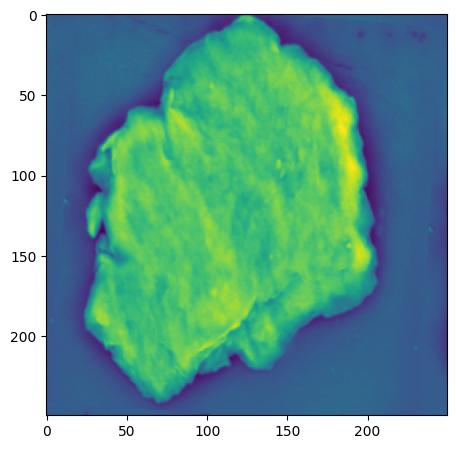

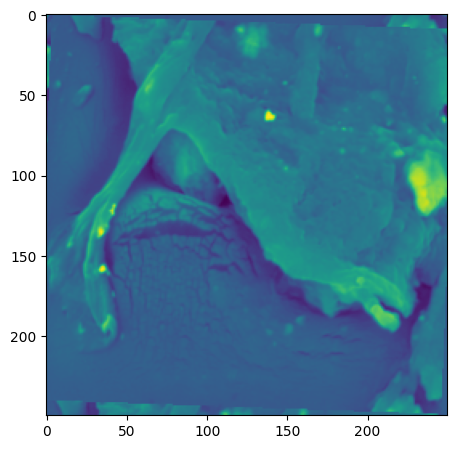

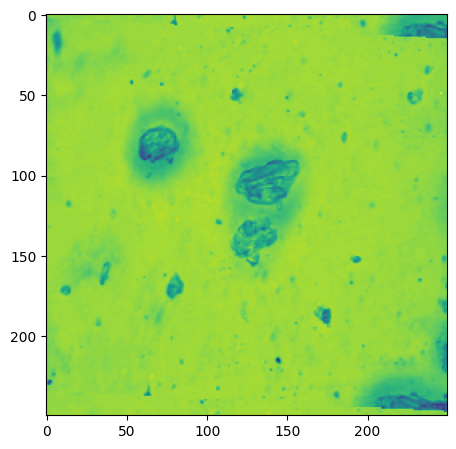

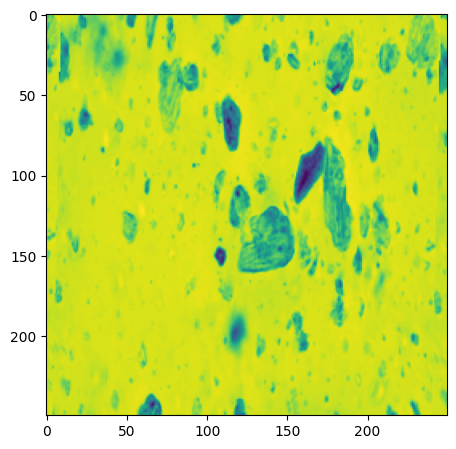

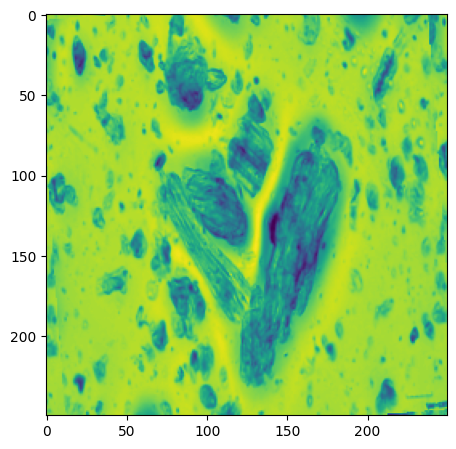

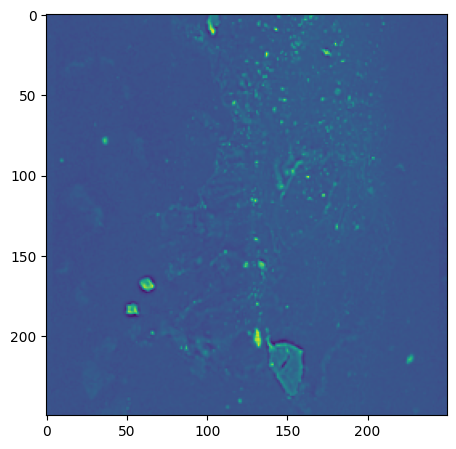

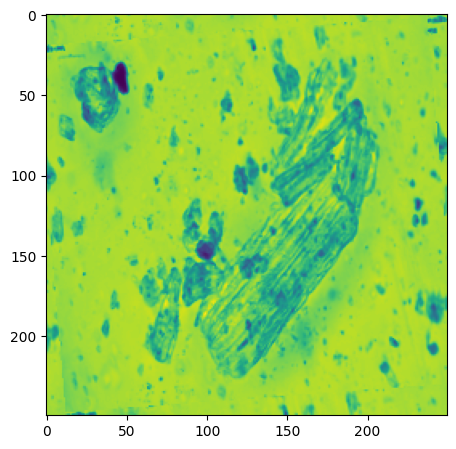

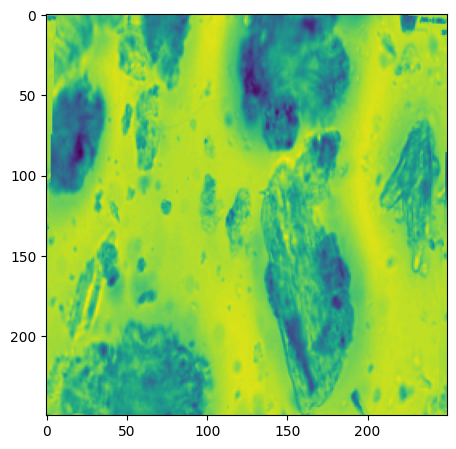

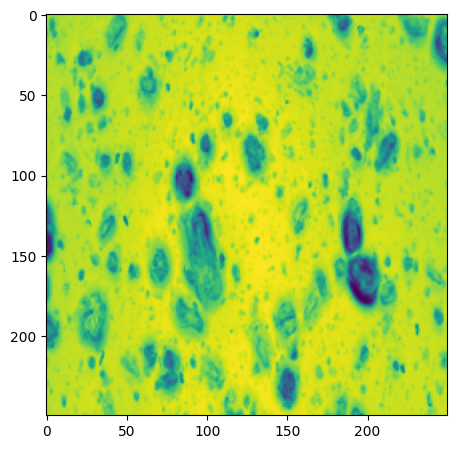

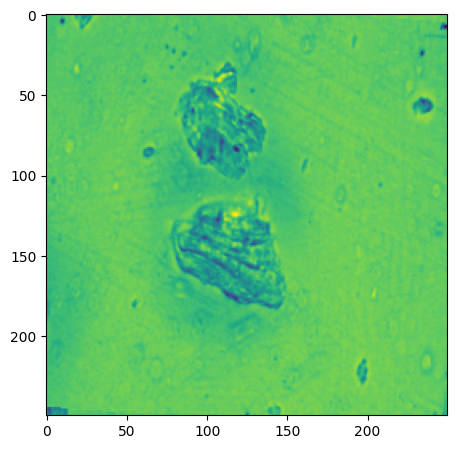

In [11]:
#Plot the generated images
for i in range(10):
  plt.figure(figsize=(30,30))
  plt.subplot(2,5,i+1)
  plt.imshow(train_images[i])


# HyperParameter optimization

## Functions

In [12]:
# Function to convert grayscale to RGB (3 channels). Inception V3 is pre-trained for RGB images
def preprocess_grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Define the custom accuracy metric
def custom_accuracy(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) / K.maximum(K.abs(y_true), K.epsilon()), axis=-1)

## Hyperparameter model

In [14]:
# Input shape for grayscale images
input_shape = (250, 250, 1)

def hp_model(hp):
    base_model = InceptionV3(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Lambda(preprocess_grayscale_to_rgb))
    model.add(base_model)

    # Add custom layers
    model.add(layers.GlobalAveragePooling2D())

    dropout_rate = hp.Float('dropout_rate', min_value=0.25, max_value=0.7, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    model.add(layers.Dense(dense_units, activation='relu'))

    model.add(layers.Dense(1))

    # Model compile
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=custom_accuracy, metrics=[custom_accuracy])

    return model

## Tuning and search for optimal hyperparameters

In [15]:
tuner = RandomSearch(
    hp_model,
    objective=kt.Objective('val_loss', direction='min'),
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='inceptionv3_transfer_learning'
)


lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


tuner.search(train_images, train_labels,
             validation_data=(test_images, test_labels),
             epochs=30,
             callbacks=[lr_reduce, early_stopping])


model = tuner.get_best_models(num_models=1)[0]


test_loss, test_custom_acc = model.evaluate(test_images, test_labels)
print(f"Found model test loss: {test_loss}, Test Accuracy: {test_custom_acc}")

Trial 20 Complete [00h 00m 50s]
val_loss: 0.046066295355558395

Best val_loss So Far: 0.034513186663389206
Total elapsed time: 00h 24m 59s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - custom_accuracy: 0.2155 - loss: 0.0338
Found model test loss: 0.034513186663389206, Test Accuracy: 0.22530846297740936


In [16]:
# Store the optimal hyperparameters in a dictionay
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hyperparams_dict = {
    'learning_rate': best_hps.get('learning_rate'),
    'dense_units': best_hps.get('dense_units'),
    'dropout_rate': best_hps.get('dropout_rate')
}

print(best_hyperparams_dict)

{'learning_rate': 0.0007719014302211909, 'dense_units': 512, 'dropout_rate': 0.35}


# Model evaluation

## Build and run the "best" model 20 times to evaluate performance

Run # 1
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - custom_accuracy: 0.3912 - loss: 0.3165 - val_custom_accuracy: 0.2292 - val_loss: 0.0809 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3147 - loss: 0.0823 - val_custom_accuracy: 0.2420 - val_loss: 0.0949 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3190 - loss: 0.0862 - val_custom_accuracy: 0.2342 - val_loss: 0.0574 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3133 - loss: 0.0714 - val_custom_accuracy: 0.2302 - val_loss: 0.0508 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3079 - loss: 0.0678 - val_custom_accuracy: 0.2345 - val_loss: 0.0484 - learning_rate: 7.7190e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3091 - loss: 0.0648 - val_custom_accuracy: 0.2356 - val_loss: 0.0525 - le

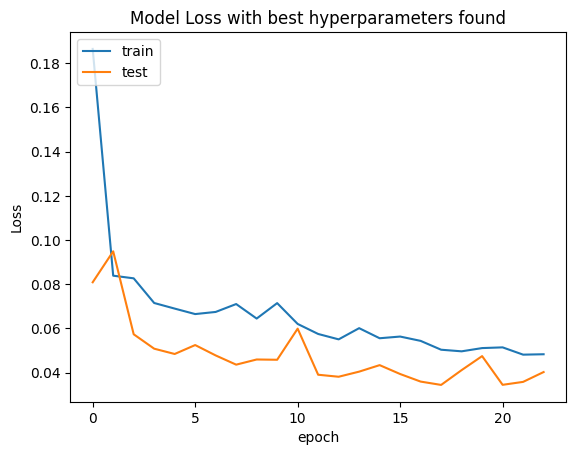

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.73
Hits within 10% error: 0.96
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3174 - loss: 0.0367
Run # 2
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - custom_accuracy: 0.4061 - loss: 0.3268 - val_custom_accuracy: 0.2345 - val_loss: 0.1012 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3128 - loss: 0.0763 - val_custom_accuracy: 0.2321 - val_loss: 0.0689 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3063 - loss: 0.0753 - val_custom_accuracy: 0.2378 - val_loss: 0.0534 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3146 - loss: 0.0820 - val_custom_accuracy: 0.2409 - val_loss: 0.0657 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3153 - loss: 0.0710 - val_custom_accuracy: 0.2346 - val_loss: 0.0512 - 

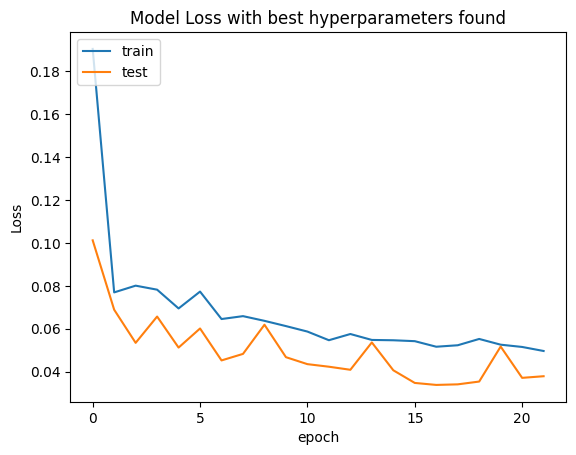

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.76
Hits within 10% error: 0.96
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3170 - loss: 0.0377
Run # 3
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 517ms/step - custom_accuracy: 0.4022 - loss: 0.3310 - val_custom_accuracy: 0.2370 - val_loss: 0.0753 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3179 - loss: 0.0861 - val_custom_accuracy: 0.2373 - val_loss: 0.0612 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3120 - loss: 0.0801 - val_custom_accuracy: 0.2267 - val_loss: 0.0558 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3129 - loss: 0.0725 - val_custom_accuracy: 0.2324 - val_loss: 0.0585 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3156 - loss: 0.0689 - val_custom_accuracy: 0.2309 - val_loss: 0.0551 - 

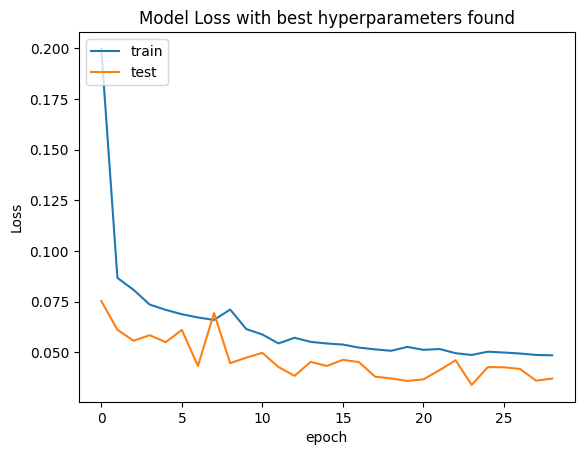

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.72
Hits within 10% error: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3161 - loss: 0.0372
Run # 4
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 526ms/step - custom_accuracy: 0.4000 - loss: 0.3324 - val_custom_accuracy: 0.2393 - val_loss: 0.0768 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3201 - loss: 0.0910 - val_custom_accuracy: 0.2319 - val_loss: 0.0608 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3109 - loss: 0.0700 - val_custom_accuracy: 0.2267 - val_loss: 0.0670 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3064 - loss: 0.0701 - val_custom_accuracy: 0.2472 - val_loss: 0.1145 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3135 - loss: 0.0882 - val_custom_accuracy: 0.2347 - val_loss: 0.0581 - 

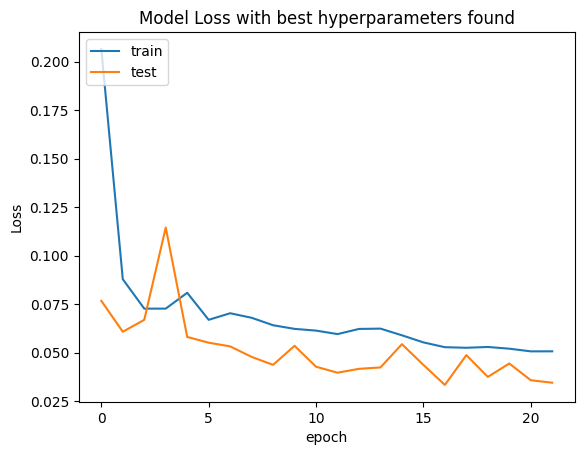

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.74
Hits within 10% error: 0.94
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3114 - loss: 0.0397
Run # 5
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 519ms/step - custom_accuracy: 0.4157 - loss: 0.3563 - val_custom_accuracy: 0.2239 - val_loss: 0.0784 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3090 - loss: 0.0802 - val_custom_accuracy: 0.2384 - val_loss: 0.0653 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3083 - loss: 0.0707 - val_custom_accuracy: 0.2395 - val_loss: 0.0525 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3133 - loss: 0.0687 - val_custom_accuracy: 0.2353 - val_loss: 0.0668 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - custom_accuracy: 0.3121 - loss: 0.0691 - val_custom_accuracy: 0.2242 - val_loss: 0.0566 - 

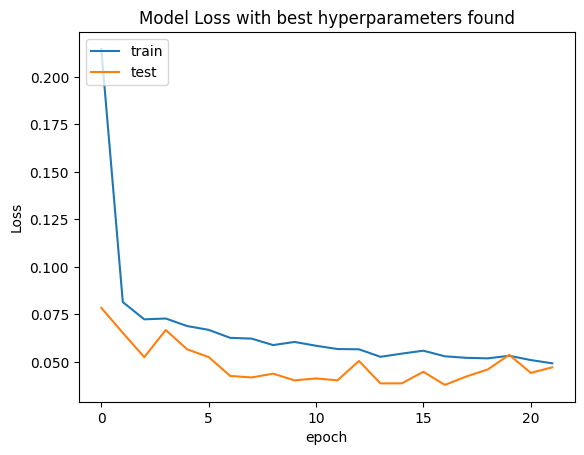

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.8
Hits within 10% error: 0.96
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3203 - loss: 0.0380
Run # 6
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 518ms/step - custom_accuracy: 0.4138 - loss: 0.3509 - val_custom_accuracy: 0.2429 - val_loss: 0.0701 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3180 - loss: 0.0896 - val_custom_accuracy: 0.2373 - val_loss: 0.0749 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3126 - loss: 0.0756 - val_custom_accuracy: 0.2291 - val_loss: 0.0653 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3130 - loss: 0.0736 - val_custom_accuracy: 0.2278 - val_loss: 0.0512 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3133 - loss: 0.0802 - val_custom_accuracy: 0.2339 - val_loss: 0.0879 - l

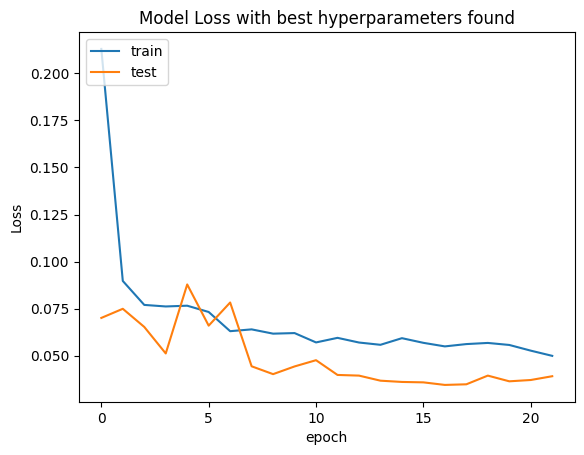

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.77
Hits within 10% error: 0.96
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3165 - loss: 0.0372
Run # 7
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - custom_accuracy: 0.4186 - loss: 0.3429 - val_custom_accuracy: 0.2223 - val_loss: 0.0763 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3162 - loss: 0.0810 - val_custom_accuracy: 0.2254 - val_loss: 0.0636 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3100 - loss: 0.0815 - val_custom_accuracy: 0.2333 - val_loss: 0.0740 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3080 - loss: 0.0687 - val_custom_accuracy: 0.2329 - val_loss: 0.0499 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3108 - loss: 0.0660 - val_custom_accuracy: 0.2504 - val_loss: 0.0948 - 

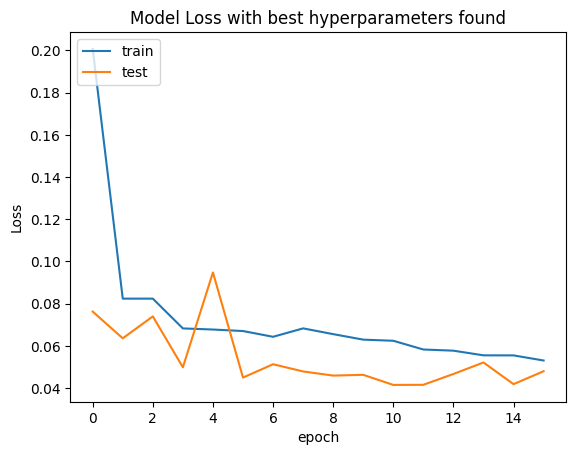

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.69
Hits within 10% error: 0.91
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3283 - loss: 0.0454
Run # 8
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - custom_accuracy: 0.4044 - loss: 0.3332 - val_custom_accuracy: 0.2468 - val_loss: 0.0896 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3187 - loss: 0.0935 - val_custom_accuracy: 0.2403 - val_loss: 0.0876 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3087 - loss: 0.0718 - val_custom_accuracy: 0.2368 - val_loss: 0.0519 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3162 - loss: 0.0851 - val_custom_accuracy: 0.2326 - val_loss: 0.0480 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3134 - loss: 0.0784 - val_custom_accuracy: 0.2287 - val_loss: 0.0627 - 

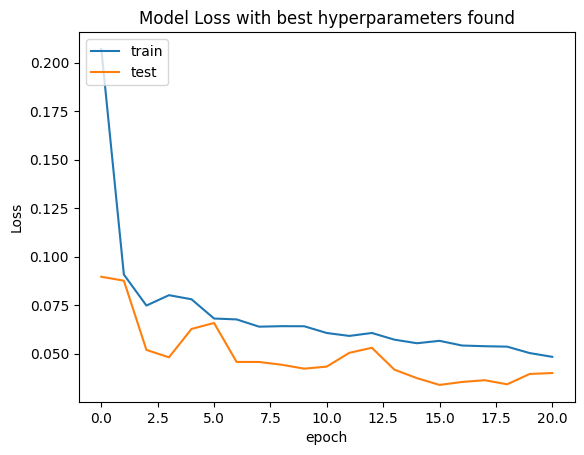

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.73
Hits within 10% error: 0.95
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3244 - loss: 0.0400
Run # 9
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - custom_accuracy: 0.4090 - loss: 0.3353 - val_custom_accuracy: 0.2610 - val_loss: 0.1133 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3277 - loss: 0.0994 - val_custom_accuracy: 0.2275 - val_loss: 0.0641 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3101 - loss: 0.0747 - val_custom_accuracy: 0.2388 - val_loss: 0.0926 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3108 - loss: 0.0713 - val_custom_accuracy: 0.2233 - val_loss: 0.0732 - learning_rate: 7.7190e-04
Epoch 5/30
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - custom_accuracy: 0.3082 - loss: 0.0678
Epoch 5: ReduceLROnPlateau reducing learning rate t

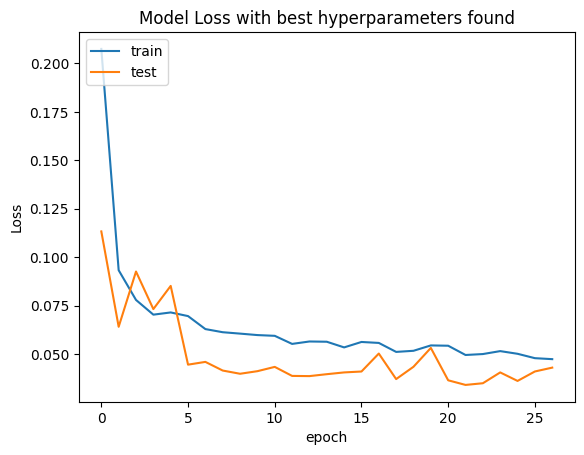

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.74
Hits within 10% error: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3191 - loss: 0.0378
Run # 10
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - custom_accuracy: 0.4009 - loss: 0.3259 - val_custom_accuracy: 0.2281 - val_loss: 0.0855 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3106 - loss: 0.0842 - val_custom_accuracy: 0.2433 - val_loss: 0.0613 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3149 - loss: 0.0816 - val_custom_accuracy: 0.2358 - val_loss: 0.0504 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - custom_accuracy: 0.3121 - loss: 0.0729 - val_custom_accuracy: 0.2434 - val_loss: 0.0697 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3134 - loss: 0.0705 - val_custom_accuracy: 0.2372 - val_loss: 0.0549 -

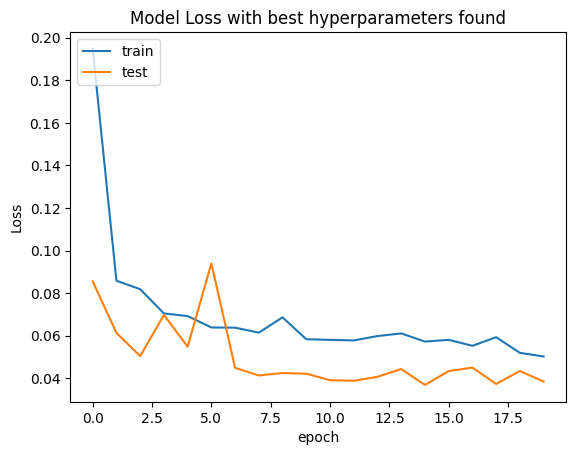

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.74
Hits within 10% error: 0.93
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3201 - loss: 0.0419
Run # 11
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 520ms/step - custom_accuracy: 0.4029 - loss: 0.3223 - val_custom_accuracy: 0.2407 - val_loss: 0.0944 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3170 - loss: 0.0888 - val_custom_accuracy: 0.2390 - val_loss: 0.0580 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - custom_accuracy: 0.3097 - loss: 0.0778 - val_custom_accuracy: 0.2370 - val_loss: 0.0685 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - custom_accuracy: 0.3093 - loss: 0.0754 - val_custom_accuracy: 0.2245 - val_loss: 0.0526 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - custom_accuracy: 0.3103 - loss: 0.0674 - val_custom_accuracy: 0.2378 - val_loss: 0.0465 -

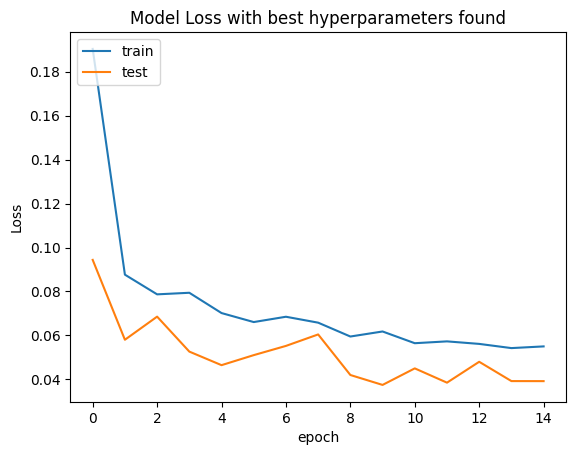

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.65
Hits within 10% error: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - custom_accuracy: 0.3190 - loss: 0.0392
Run # 12
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - custom_accuracy: 0.3922 - loss: 0.3155 - val_custom_accuracy: 0.2316 - val_loss: 0.1005 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3133 - loss: 0.0804 - val_custom_accuracy: 0.2357 - val_loss: 0.0762 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3124 - loss: 0.0753 - val_custom_accuracy: 0.2446 - val_loss: 0.0934 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3131 - loss: 0.0701 - val_custom_accuracy: 0.2436 - val_loss: 0.0586 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3095 - loss: 0.0709 - val_custom_accuracy: 0.2277 - val_loss: 0.0519 -

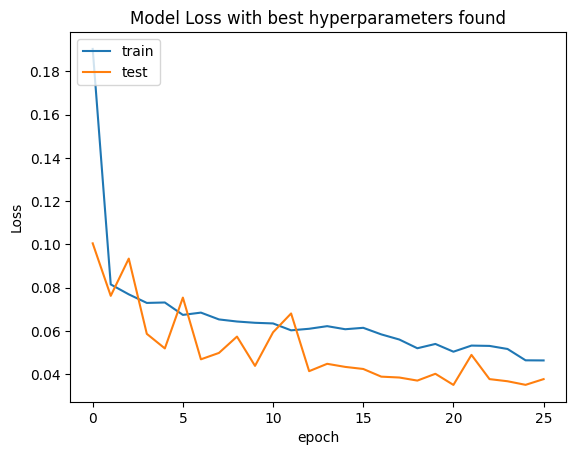

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.72
Hits within 10% error: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3153 - loss: 0.0389
Run # 13
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 521ms/step - custom_accuracy: 0.4023 - loss: 0.3266 - val_custom_accuracy: 0.2383 - val_loss: 0.0730 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3134 - loss: 0.0928 - val_custom_accuracy: 0.2372 - val_loss: 0.0592 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3136 - loss: 0.0727 - val_custom_accuracy: 0.2312 - val_loss: 0.0506 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3098 - loss: 0.0711 - val_custom_accuracy: 0.2365 - val_loss: 0.0470 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3124 - loss: 0.0689 - val_custom_accuracy: 0.2336 - val_loss: 0.0903 -

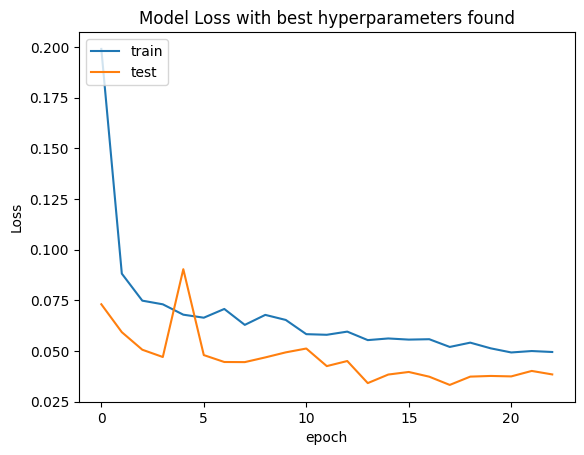

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.77
Hits within 10% error: 0.94
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3205 - loss: 0.0386
Run # 14
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 524ms/step - custom_accuracy: 0.4116 - loss: 0.3404 - val_custom_accuracy: 0.2453 - val_loss: 0.0907 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3162 - loss: 0.0846 - val_custom_accuracy: 0.2326 - val_loss: 0.0605 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3160 - loss: 0.0729 - val_custom_accuracy: 0.2319 - val_loss: 0.0688 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3124 - loss: 0.0779 - val_custom_accuracy: 0.2296 - val_loss: 0.0568 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3059 - loss: 0.0665 - val_custom_accuracy: 0.2314 - val_loss: 0.0480 -

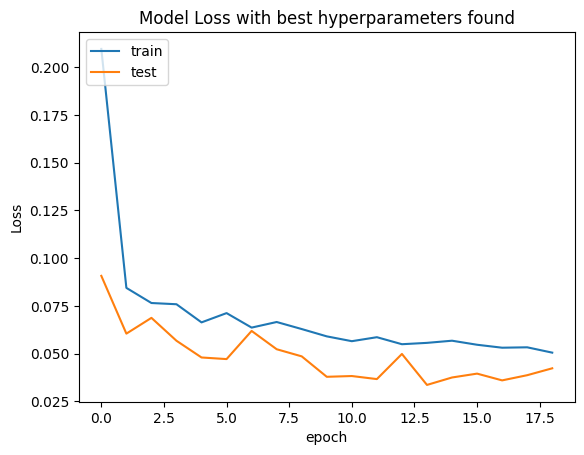

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.73
Hits within 10% error: 0.99
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3217 - loss: 0.0376
Run # 15
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 522ms/step - custom_accuracy: 0.4122 - loss: 0.3399 - val_custom_accuracy: 0.2277 - val_loss: 0.0734 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3163 - loss: 0.0875 - val_custom_accuracy: 0.2325 - val_loss: 0.0645 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3093 - loss: 0.0714 - val_custom_accuracy: 0.2326 - val_loss: 0.0535 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3122 - loss: 0.0705 - val_custom_accuracy: 0.2326 - val_loss: 0.0554 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3118 - loss: 0.0664 - val_custom_accuracy: 0.2349 - val_loss: 0.0499 -

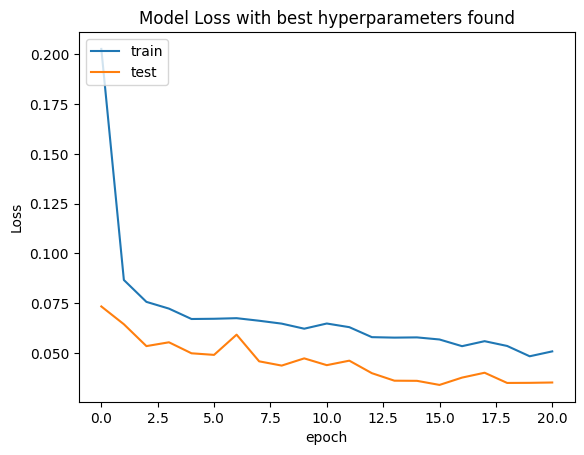

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.74
Hits within 10% error: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3266 - loss: 0.0366
Run # 16
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 527ms/step - custom_accuracy: 0.3983 - loss: 0.3191 - val_custom_accuracy: 0.2376 - val_loss: 0.0834 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3196 - loss: 0.0789 - val_custom_accuracy: 0.2348 - val_loss: 0.0701 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3097 - loss: 0.0791 - val_custom_accuracy: 0.2387 - val_loss: 0.0579 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3171 - loss: 0.0753 - val_custom_accuracy: 0.2384 - val_loss: 0.0658 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3086 - loss: 0.0763 - val_custom_accuracy: 0.2377 - val_loss: 0.0602 -

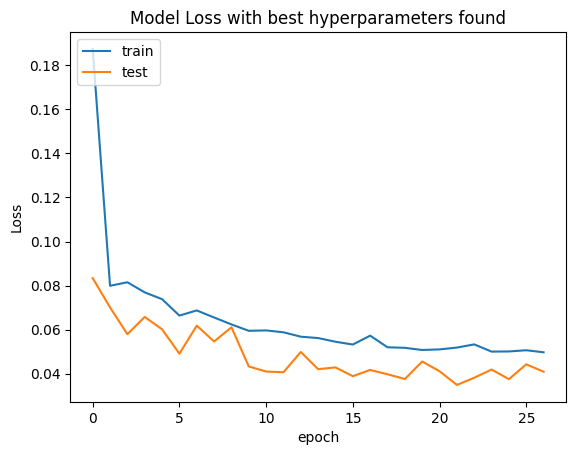

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.71
Hits within 10% error: 0.99
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - custom_accuracy: 0.3202 - loss: 0.0383
Run # 17
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - custom_accuracy: 0.4106 - loss: 0.3477 - val_custom_accuracy: 0.2597 - val_loss: 0.0948 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - custom_accuracy: 0.3235 - loss: 0.0956 - val_custom_accuracy: 0.2260 - val_loss: 0.0630 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3110 - loss: 0.0768 - val_custom_accuracy: 0.2336 - val_loss: 0.0795 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3078 - loss: 0.0716 - val_custom_accuracy: 0.2340 - val_loss: 0.0523 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3170 - loss: 0.0694 - val_custom_accuracy: 0.2325 - val_loss: 0.0498 -

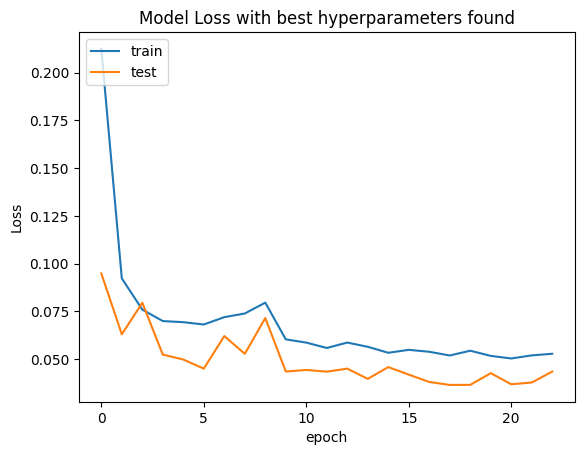

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.75
Hits within 10% error: 0.95
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - custom_accuracy: 0.3242 - loss: 0.0410
Run # 18
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - custom_accuracy: 0.3992 - loss: 0.3203 - val_custom_accuracy: 0.2420 - val_loss: 0.0944 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3198 - loss: 0.0834 - val_custom_accuracy: 0.2423 - val_loss: 0.0961 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3135 - loss: 0.0712 - val_custom_accuracy: 0.2277 - val_loss: 0.0736 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3069 - loss: 0.0700 - val_custom_accuracy: 0.2374 - val_loss: 0.0555 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3092 - loss: 0.0739 - val_custom_accuracy: 0.2317 - val_loss: 0.0803 -

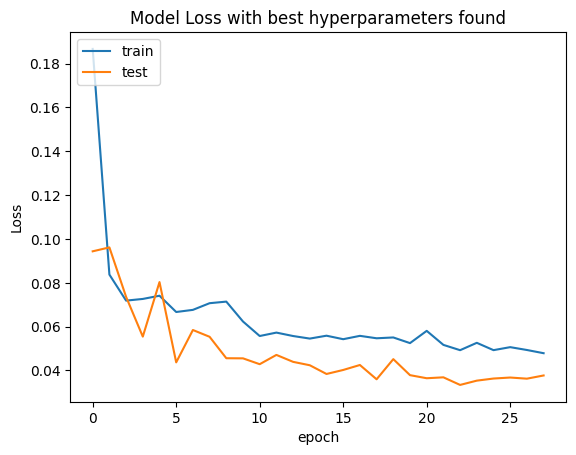

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.76
Hits within 10% error: 0.95
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3269 - loss: 0.0391
Run # 19
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 522ms/step - custom_accuracy: 0.4130 - loss: 0.3515 - val_custom_accuracy: 0.2411 - val_loss: 0.0733 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3178 - loss: 0.0848 - val_custom_accuracy: 0.2390 - val_loss: 0.0647 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3146 - loss: 0.0769 - val_custom_accuracy: 0.2343 - val_loss: 0.0758 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3102 - loss: 0.0710 - val_custom_accuracy: 0.2265 - val_loss: 0.0582 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3100 - loss: 0.0660 - val_custom_accuracy: 0.2381 - val_loss: 0.0558 -

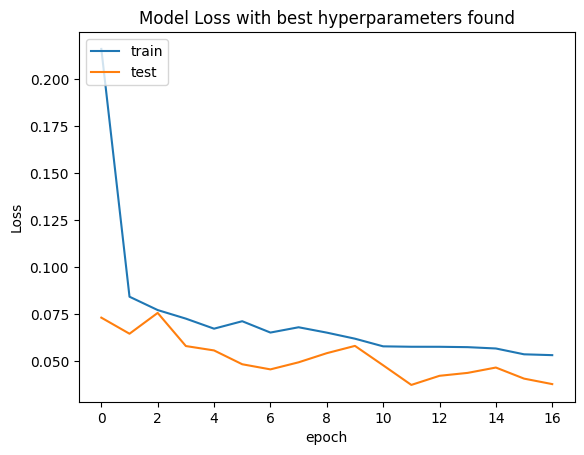

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.71
Hits within 10% error: 0.95
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3213 - loss: 0.0404
Run # 20
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 520ms/step - custom_accuracy: 0.4084 - loss: 0.3388 - val_custom_accuracy: 0.2325 - val_loss: 0.0763 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3151 - loss: 0.0777 - val_custom_accuracy: 0.2306 - val_loss: 0.0840 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3137 - loss: 0.0760 - val_custom_accuracy: 0.2258 - val_loss: 0.0607 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - custom_accuracy: 0.3084 - loss: 0.0749 - val_custom_accuracy: 0.2436 - val_loss: 0.0626 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - custom_accuracy: 0.3142 - loss: 0.0751 - val_custom_accuracy: 0.2363 - val_loss: 0.0498 -

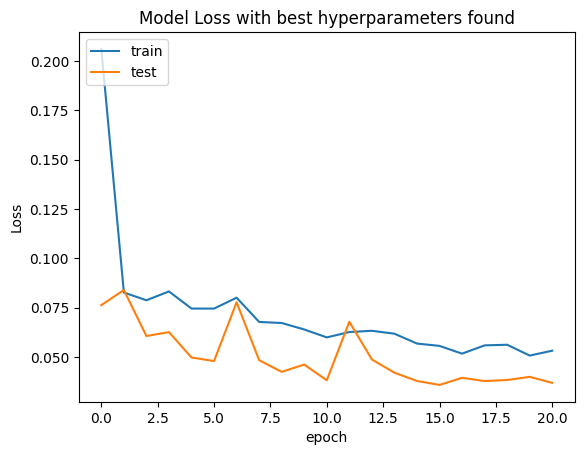

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Hits within 5% error: 0.75
Hits within 10% error: 0.93
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - custom_accuracy: 0.3243 - loss: 0.0391
Run # 21
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 521ms/step - custom_accuracy: 0.3886 - loss: 0.3147 - val_custom_accuracy: 0.2456 - val_loss: 0.1176 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3231 - loss: 0.0862 - val_custom_accuracy: 0.2369 - val_loss: 0.0651 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - custom_accuracy: 0.3136 - loss: 0.0735 - val_custom_accuracy: 0.2262 - val_loss: 0.0527 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - custom_accuracy: 0.3142 - loss: 0.0710 - val_custom_accuracy: 0.2365 - val_loss: 0.0932 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - custom_accuracy: 0.3050 - loss: 0.0693 - val_custom_accuracy: 0.2266 - val_loss: 0.0485 -

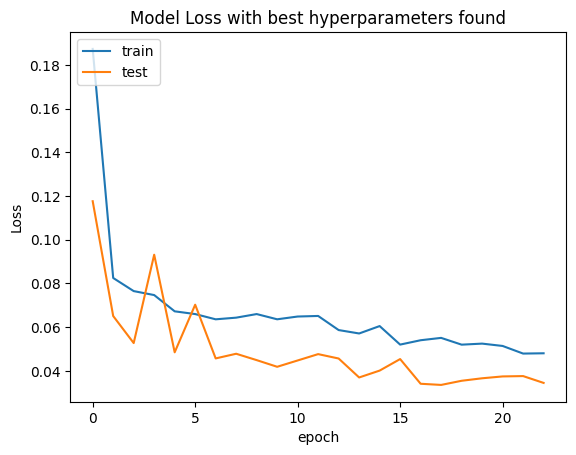

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.68
Hits within 10% error: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - custom_accuracy: 0.3144 - loss: 0.0391
Run # 22
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 517ms/step - custom_accuracy: 0.3881 - loss: 0.3099 - val_custom_accuracy: 0.2495 - val_loss: 0.0965 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3246 - loss: 0.0842 - val_custom_accuracy: 0.2426 - val_loss: 0.1017 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3165 - loss: 0.0772 - val_custom_accuracy: 0.2423 - val_loss: 0.0692 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3102 - loss: 0.0676 - val_custom_accuracy: 0.2428 - val_loss: 0.0879 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - custom_accuracy: 0.3121 - loss: 0.0715 - val_custom_accuracy: 0.2327 - val_loss: 0.1001 -

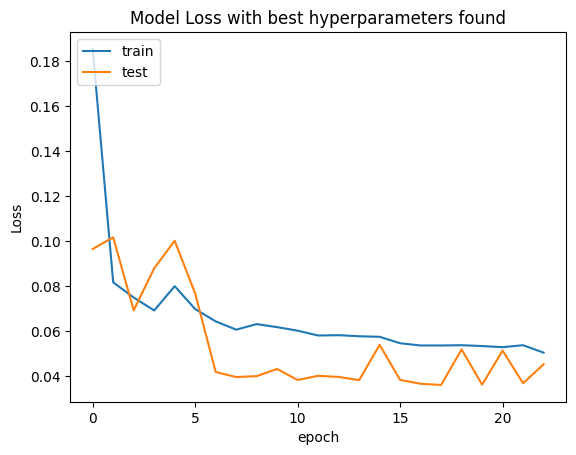

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.74
Hits within 10% error: 0.95
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - custom_accuracy: 0.3236 - loss: 0.0410
Run # 23
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 520ms/step - custom_accuracy: 0.4149 - loss: 0.3554 - val_custom_accuracy: 0.2491 - val_loss: 0.0804 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3220 - loss: 0.0992 - val_custom_accuracy: 0.2290 - val_loss: 0.0758 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - custom_accuracy: 0.3069 - loss: 0.0743 - val_custom_accuracy: 0.2438 - val_loss: 0.0821 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3143 - loss: 0.0718 - val_custom_accuracy: 0.2256 - val_loss: 0.0640 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - custom_accuracy: 0.3091 - loss: 0.0716 - val_custom_accuracy: 0.2301 - val_loss: 0.0515 -

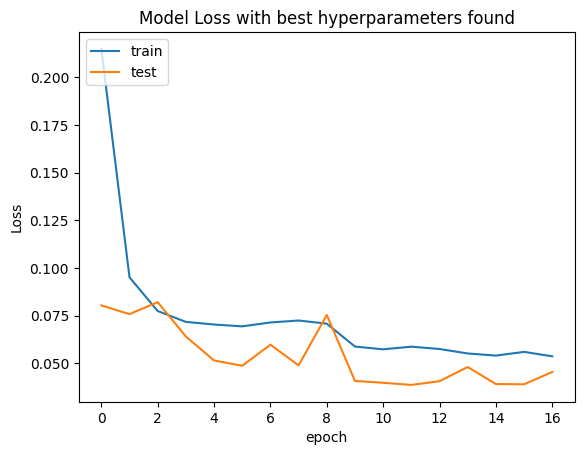

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.69
Hits within 10% error: 0.92
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3315 - loss: 0.0428
Run # 24
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - custom_accuracy: 0.4104 - loss: 0.3417 - val_custom_accuracy: 0.2309 - val_loss: 0.0732 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3160 - loss: 0.0851 - val_custom_accuracy: 0.2393 - val_loss: 0.0586 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - custom_accuracy: 0.3101 - loss: 0.0785 - val_custom_accuracy: 0.2334 - val_loss: 0.0533 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - custom_accuracy: 0.3100 - loss: 0.0697 - val_custom_accuracy: 0.2389 - val_loss: 0.0503 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - custom_accuracy: 0.3118 - loss: 0.0704 - val_custom_accuracy: 0.2306 - val_loss: 0.0512 -

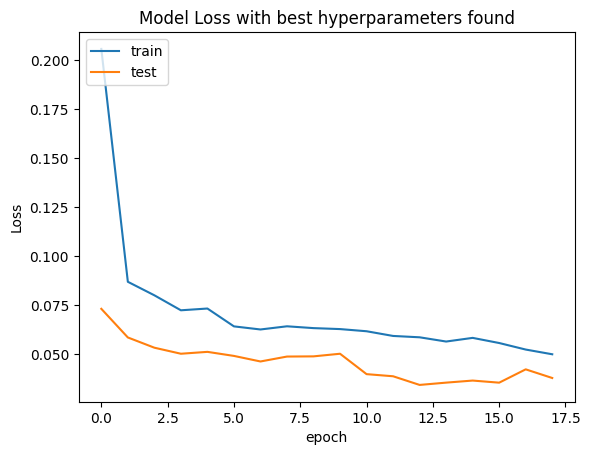

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.7
Hits within 10% error: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - custom_accuracy: 0.3237 - loss: 0.0439
Run # 25
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 527ms/step - custom_accuracy: 0.4242 - loss: 0.3633 - val_custom_accuracy: 0.2529 - val_loss: 0.0772 - learning_rate: 7.7190e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - custom_accuracy: 0.3233 - loss: 0.0947 - val_custom_accuracy: 0.2262 - val_loss: 0.1033 - learning_rate: 7.7190e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3053 - loss: 0.0830 - val_custom_accuracy: 0.2379 - val_loss: 0.0638 - learning_rate: 7.7190e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3129 - loss: 0.0756 - val_custom_accuracy: 0.2337 - val_loss: 0.0556 - learning_rate: 7.7190e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - custom_accuracy: 0.3131 - loss: 0.0725 - val_custom_accuracy: 0.2268 - val_loss: 0.0482 - 

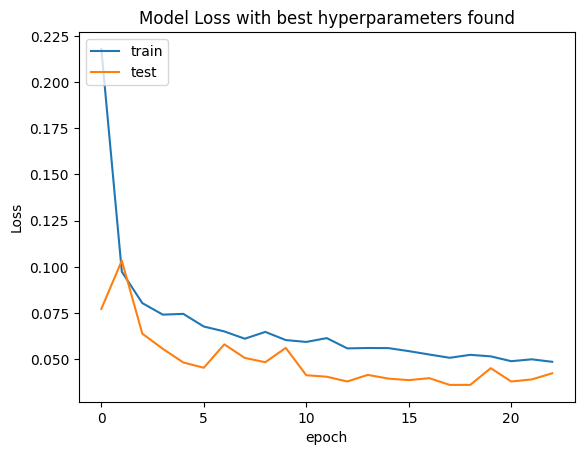

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.69
Hits within 10% error: 0.96
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - custom_accuracy: 0.3188 - loss: 0.0413


In [17]:
# Initialize lists to store results
l_hits5 = []
l_hits10 = []
l_loss = []

# Run the model 20 times for statistics
for i in range(25):
  print("Run #", 1+i)
  # Build the model with the tuned hyperparameters using Functional API
  def build_model_with_best_params():
      input_shape = (250, 250, 1)

      inputs = layers.Input(shape=input_shape)


      x = layers.Lambda(preprocess_grayscale_to_rgb)(inputs)


      base_model = InceptionV3(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
      base_model.trainable = False


      x = base_model(x)


      x = layers.GlobalAveragePooling2D()(x)
      x = layers.Dropout(best_hyperparams_dict['dropout_rate'])(x)
      x = layers.Dense(best_hyperparams_dict['dense_units'], activation='relu')(x)


      outputs = layers.Dense(1)(x)


      model = models.Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparams_dict['learning_rate']),
                    loss=custom_accuracy,
                    metrics=[custom_accuracy])

      return model

  lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model = build_model_with_best_params()


  history = model.fit(train_images, train_labels,
                      epochs=30,
                      validation_data=(test_images, test_labels),
                      callbacks=[lr_reduce, early_stopping])

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss with best hyperparameters found')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  predictions_test = model.predict(val_images)

  count = 0
  for i in range(len(predictions_test)):
      error = float(abs(predictions_test[i] - val_labels[i]) * 100 / val_labels[i])
      if error <= 5.00:
          count += 1

  print(f"Hits within 5% error: {count/len(predictions_test)}")
  l_hits5.append(count/len(predictions_test))


  count = 0
  for i in range(len(predictions_test)):
      error = float(abs(predictions_test[i] - val_labels[i]) * 100 / val_labels[i])
      if error <= 10.00:
          count += 1

  print(f"Hits within 10% error: {count/len(predictions_test)}")
  l_hits10.append(count/len(predictions_test))

  loss = model.evaluate(val_images, val_labels)
  l_loss.append(loss[1])

## Statistics

In [18]:
mean5 = statistics.mean(l_hits5)
mean10 = statistics.mean(l_hits10)
mean_loss = statistics.mean(l_loss)


stdev5 = statistics.stdev(l_hits5)
stdev10 = statistics.stdev(l_hits10)
stdev_loss = statistics.stdev(l_loss)


print(f"Mean (5% margin): {mean5}")
print(f"Mean (10% margin): {mean10}")
print(f"Mean Loss: {mean_loss}\n")
print(f"Standard Deviation (5% margin): {stdev5}")
print(f"Standard Deviation (10% margin): {stdev10}")
print(f"Standard Deviation Loss: {stdev_loss}")


Mean (5% margin): 0.7283999999999999
Mean (10% margin): 0.9556
Mean Loss: 0.3127528965473175

Standard Deviation (5% margin): 0.033376638536557285
Standard Deviation (10% margin): 0.019595917942265412
Standard Deviation Loss: 0.004416411826854125


# Save the trained model

In [19]:
model.save('optimal_hyperparameters_transfer_learning_model.h5')

In [20]:
predictions = model.predict(images/250)

count = 0
for i in range(len(predictions)):
    error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
    if error <= 5.00:
        count += 1

print(f"Hits within 5% error: {count/len(predictions)}")



count = 0
for i in range(len(predictions)):
    error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
    if error <= 10.00:
        count += 1

print(f"Hits within 10% error: {count/len(predictions)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Hits within 5% error: 0.574468085106383
Hits within 10% error: 0.8085106382978723


<ipython-input-20-f97e83a9ed1f>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
<ipython-input-20-f97e83a9ed1f>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])


# Save hyperparameters tunings (optional)

In [21]:
!zip -r /content/file.zip /content/hyperparam_tuning

  adding: content/hyperparam_tuning/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/trial.json (deflated 65%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/checkpoint.weights.h5 (deflated 8%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/trial.json (deflated 65%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/checkpoint.weights.h5 (deflated 8%)
  adding: content/hyperparam_tuning/inceptionv3_transfer

In [22]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>